In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import sys
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

In [2]:
writer = SummaryWriter('runs/mnist1')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [47]:
input_size = 784
hidden_size = 500
num_classes = 10
num_epochs = 10
batch_size = 64
learning_rate = 0.1


In [11]:
train_dataset = torchvision.datasets.MNIST(root='data',
                                          train = True,
                                          transform = transforms.ToTensor(),
                                          download=True)
test_dataset = torchvision.datasets.MNIST(root='data',
                                          train = False,
                                          transform = transforms.ToTensor(),
                                          download=True)

/home/aarav/anaconda3/envs/pract/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [12]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [13]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [14]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = batch_size,
                                          shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset= test_dataset,
                                         batch_size = batch_size,
                                         shuffle = False)

In [15]:
examples = iter(test_loader)
example_data,example_targets = examples.next()

In [17]:
example_data.shape

torch.Size([64, 1, 28, 28])

In [18]:
example_targets

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])

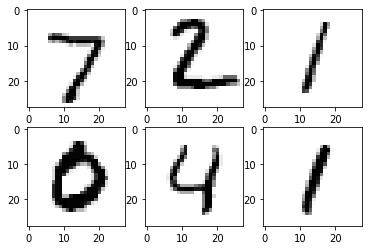

In [20]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0],cmap='gray_r')
plt.show()

In [21]:
img_grid = torchvision.utils.make_grid(example_data)

In [22]:
writer.add_image('mnist_images',img_grid)

In [34]:
writer.close()
sys.exit()

SystemExit: 

/home/aarav/anaconda3/envs/pract/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [32]:
!tensorboard --logdir runs/mnist1


2022-07-01 11:51:38.918818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 11:51:38.971787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 11:51:38.972023: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.6.0 at http://localhost:6006/ (Press CTRL

In [28]:
class NeuralNet(nn.Module):
    def __init__(self,input_size,hidden_size,num_classes):
        super(NeuralNet,self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size,hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size,num_classes)
    def forward(self,x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out

In [29]:
model = NeuralNet(input_size,hidden_size,num_classes).to(device)

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
example_data = example_data.to(device)
writer.add_graph(model,example_data.reshape(-1,28*28))

In [36]:
!tensorboard --logdir runs/mnist1

2022-07-01 11:53:23.037413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 11:53:23.061125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 11:53:23.061388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.6.0 at http://localhost:6006/ (Press CTRL

In [41]:
running_loss = 0.0
running_corect = 0
n_total_steps = len(test_loader)

In [48]:
for epoch in range(num_epochs):
    for i,(image,labels) in enumerate(train_loader):
        image = image.reshape(-1,28*28).to(device)
        labels = labels.to(device)
        outputs = model(image)
        loss = criterion(outputs,labels)
        optimizer.zero_grad()
        running_loss += loss.item()
        _,predicted = torch.max(outputs.data ,1)
        running_corect += (predicted==labels).sum().item()
        if (i+1) % 100 == 0:
            print(f'epoch[{epoch+1}/{num_epochs}],step[{i+1}/{n_taotal_steps}],Loss:{loss.item():.4f}')
            writer.add_scalar('training loss',running_loss/100,epoch*n_total_steps+i)
            running_accuracy = running_corect/100/predicted.size(0)
            writer.add_scalar('accuracy', running_accuracy, epoch * n_total_steps + i)
            running_correct = 0
            running_loss = 0.0

epoch[1/10],step[100/157],Loss:2.3238
epoch[1/10],step[200/157],Loss:2.3058
epoch[1/10],step[300/157],Loss:2.3080
epoch[1/10],step[400/157],Loss:2.3054
epoch[1/10],step[500/157],Loss:2.3130
epoch[1/10],step[600/157],Loss:2.3164
epoch[1/10],step[700/157],Loss:2.3168
epoch[1/10],step[800/157],Loss:2.3088
epoch[1/10],step[900/157],Loss:2.3176
epoch[2/10],step[100/157],Loss:2.3137
epoch[2/10],step[200/157],Loss:2.3098
epoch[2/10],step[300/157],Loss:2.3149
epoch[2/10],step[400/157],Loss:2.3097
epoch[2/10],step[500/157],Loss:2.3095
epoch[2/10],step[600/157],Loss:2.3132
epoch[2/10],step[700/157],Loss:2.3043
epoch[2/10],step[800/157],Loss:2.3171
epoch[2/10],step[900/157],Loss:2.3106
epoch[3/10],step[100/157],Loss:2.3167
epoch[3/10],step[200/157],Loss:2.3047
epoch[3/10],step[300/157],Loss:2.3143
epoch[3/10],step[400/157],Loss:2.3121
epoch[3/10],step[500/157],Loss:2.3137
epoch[3/10],step[600/157],Loss:2.3223
epoch[3/10],step[700/157],Loss:2.3056
epoch[3/10],step[800/157],Loss:2.3049
epoch[3/10],

In [46]:
!tensorboard --logdir runs/mnist1

2022-07-01 12:08:28.925332: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 12:08:28.947211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-01 12:08:28.947387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.6.0 at http://localhost:6006/ (Press CTRL